# (sqrt) **MLP**

---

## 0. Importing dependencies

In [75]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from tensorflow import keras
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Activation, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import warnings

warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [76]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [77]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Slovakia', 'Country_Uzbekistan', 'Country_Armenia', 'Country_United Arab Emirates', 'Country_Malta', 'Country_Serbia', 'Country_El Salvador', 'Country_Azerbaijan', 'Country_Lebanon', 'Country_Tanzania', 'Country_Andorra', 'Country_Bosnia-Herz.', 'Country_Sri Lanka', 'Country_Bangladesh', 'Country_North Macedonia', 'Country_Viet Nam', 'Country_Latvia', 'Country_Kosovo', 'Country_Georgia', 'Country_Philippines', 'Country_Costa Rica', 'Country_Venezuela', 'Country_Paraguay', 'Country_Saudi Arabia', 'Country_Zimbabwe', 'Country_Mongolia', 'Country_Estonia', 'Country_Croatia', 'Country_New Zealand', 'Country_Peru', 'Country_Nomadic', 'Country_Yemen', 'Country_Botswana', 'Country_Angola', 'Ethnicity_North American / Central American', 'Country_Cyprus', 'Country_Jordan', 'Country_Kenya'}
Columns in the test set that aren't in the train set: {'Country_Belarus', 'Country_Qatar', 'Country_Barbados', 'Country_Senegal', "Country_CÃ´te

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [78]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Colombia,Country_Czech Republic,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Iran,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Kazakhstan,Country_Lithuania,Country_Luxembourg,Country_Malaysia,Country_Mexico,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Singapore,Country_Slovenia,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_UK & Northern Ireland,Country_USA,Country_Ukraine,Country_Uruguay,Academic researcher,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,12.2,62820.0


In [79]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2258, 92)
(2258,)

(553, 92)
(553,)


---

### 2.2. Identifying the target

In [80]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [81]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importnce
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

Without L1 reg:

In [82]:
def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init))
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init))  
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init))  
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model


With L1 reg:

In [83]:
'''from keras.regularizers import l1

def create_model(optimizer='adam', init='uniform', batch_size=32, 
                 activation='relu', dropout_rate=0.0, extra_layer=True,
                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons, kernel_initializer=init, 
                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
    if activation == 'leakyrelu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Activation(activation))
        
    model.add(Dropout(dropout_rate))
    
    if extra_layer == True:
        model.add(Dense(neurons, kernel_initializer=init, 
                        activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here
        if activation == 'leakyrelu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(Activation(activation))
            
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  
    model.compile(loss=loss, optimizer=optimizer)
    
    return model'''



"from keras.regularizers import l1\n\ndef create_model(optimizer='adam', init='uniform', batch_size=32, \n                 activation='relu', dropout_rate=0.0, extra_layer=True,\n                 neurons=64, loss='huber_loss', epochs=25, l1_reg=0.01):\n    model = Sequential()\n    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    \n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    model.add(Dense(neurons, kernel_initializer=init, \n                    activity_regularizer=l1(l1_reg)))  # Adding L1 regularization here\n    if activation == 'leakyrelu':\n        model.add(LeakyReLU(alpha=0.1))\n    else:\n        model.add(Activation(activation))\n        \n    model.add(Dropout(dropout_rate))\n    \n    if extra_layer == True:\

In [84]:
model = KerasRegressor(build_fn=create_model, verbose=0)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    'epochs': [10, 15], # tried with 25
    'batch_size': [64, 16], # tried with 16 nd 64
    'optimizer': ['Adam', 'Nadam'], # tried with RMSProp, SDG, Nadam
    'activation': ['leakyrelu', 'relu'], # tired with elu, relu
    'init': ['he_normal', 'he_uniform'],
    # 'dropout_rate': [0.1 ,0.2], # tried with 0.3, 0.2
    'neurons': [64, 128], # tried with 128 and 256
    'loss':['mse'], # tried with mse
    'extra_layer': [False] # Tried with False
    #, 'l1_reg': [0.001, 0.01]
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True, n_iter=10,
                   n_jobs=-1, random_state=42, verbose=2)

clf .fit(X_train_scaled, y_train)

best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'optimizer': 'Nadam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 15, 'batch_size': 16, 'activation': 'relu'}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [85]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.670042,0.571894,29209.415868,33230.901821
1,0.712148,0.572853,27283.216790,33188.644325
2,0.623944,0.558918,31183.444852,33733.335437
3,0.635398,0.563549,30705.529580,33558.573840
4,0.617942,0.562230,31430.776091,33608.424445
5,0.594663,0.543162,32369.969588,34326.491787
6,0.668072,0.574716,29298.850901,33108.310774
7,0.643013,0.571682,30383.141614,33233.161512
8,0.685411,0.573470,28520.918553,33173.486056
9,0.699072,0.576174,27892.289354,33058.996561


Now, the average of folds:

In [86]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.6549704825358738
Mean CV Train RMSE: 29827.75531900056
--------------------
Mean CV Test R2: 0.5668646724508919
Mean CV Test RMSE: 33422.032655919465


In [87]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }
        results_df = results_df.append(fold_results, ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.676169,0.54914,29185.411963,33241.345897
2,0.717737,0.548412,27247.922629,33268.177715
3,0.627195,0.54752,31314.62241,33301.01151
4,0.630488,0.550568,31176.03779,33188.664657
5,0.623147,0.55231,31484.190782,33124.282754
6,0.598457,0.519591,32499.193857,34313.376187
7,0.663203,0.551899,29763.94422,33139.478515
8,0.644583,0.552312,30575.636609,33124.203355
9,0.693649,0.556759,28386.783261,32959.272391


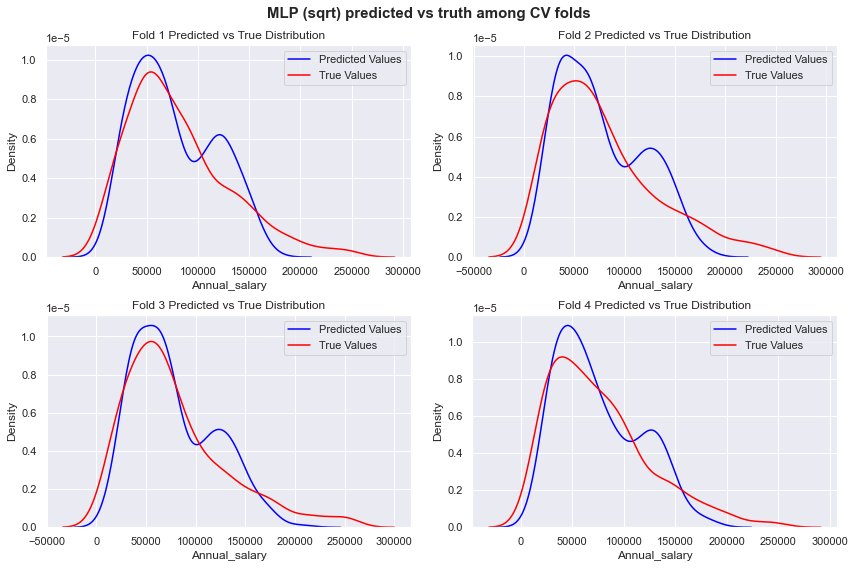

In [88]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('MLP (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [89]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train set results


Train set metrics:
R^2: 0.6946844586632648
RMSE: 28102.229016292913
Adjusted R^2: 0.6817103109482627


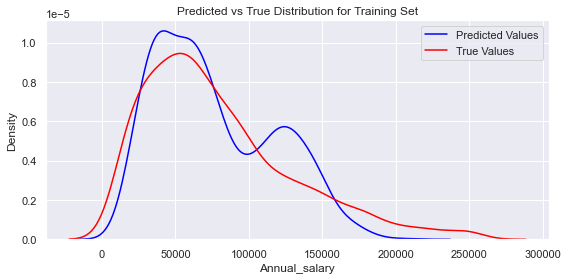

In [90]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6260557090065435
RMSE: 30301.954318844484
Adjusted R^2: 0.5512668508078522


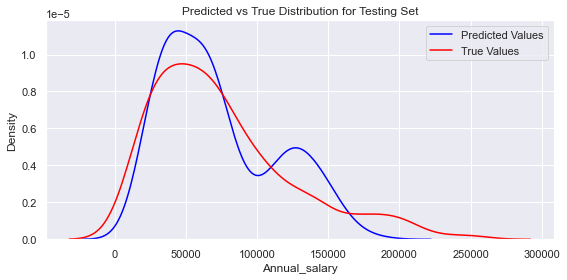

In [91]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")
    
y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

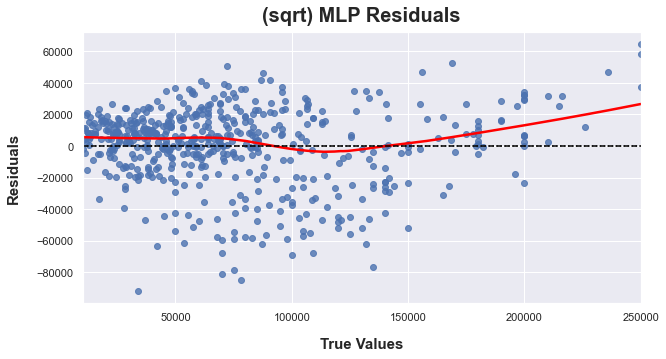

In [93]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) MLP Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-xgb-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

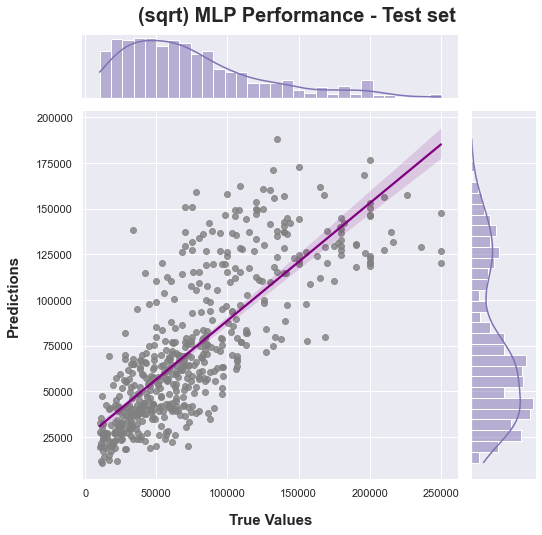

In [94]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) MLP Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb-test-predictions.pdf");

### 4.3. Train vs Test loss

Epoch 1/15
142/142 [==============================] - 2s 4ms/step - loss: 39737.8359 - val_loss: 6817.1143
Epoch 2/15
142/142 [==============================] - 0s 3ms/step - loss: 4217.7754 - val_loss: 3586.2671
Epoch 3/15
142/142 [==============================] - 0s 3ms/step - loss: 3157.4211 - val_loss: 3057.6240
Epoch 4/15
142/142 [==============================] - 0s 3ms/step - loss: 2883.4939 - val_loss: 2826.6128
Epoch 5/15
142/142 [==============================] - 0s 3ms/step - loss: 2720.1423 - val_loss: 2814.7634
Epoch 6/15
142/142 [==============================] - 0s 3ms/step - loss: 2630.2292 - val_loss: 2676.8140
Epoch 7/15
142/142 [==============================] - 0s 3ms/step - loss: 2529.8191 - val_loss: 2644.3262
Epoch 8/15
142/142 [==============================] - 0s 3ms/step - loss: 2469.6096 - val_loss: 2598.6157
Epoch 9/15
142/142 [==============================] - 0s 3ms/step - loss: 2414.5403 - val_loss: 2575.8882
Epoch 10/15
142/142 [========================

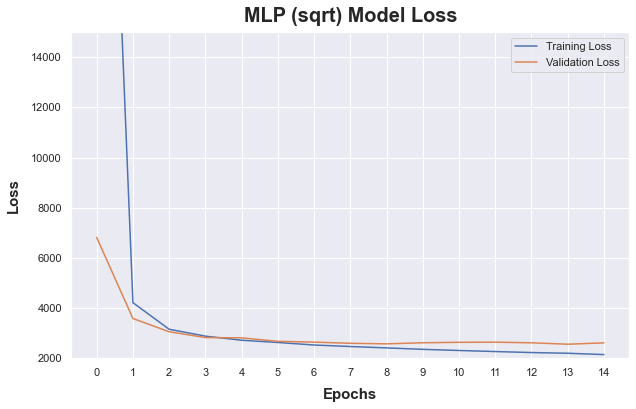

In [103]:
best_model = create_model(**best_params)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test), 
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

num_epochs = best_params['epochs']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('MLP (sqrt) Model Loss', fontsize=20, weight='bold', pad=10)
plt.xlabel('Epochs', fontsize=15, weight='bold', labelpad=10)
plt.ylabel('Loss', fontsize=15, weight='bold', labelpad=10)

plt.xticks(np.arange(0, num_epochs, step=1))
plt.ylim(2000, 15000)
plt.legend()
plt.savefig("../../paper/models/actual-mlp-train-vs-test-loss.pdf")
plt.show()

## 6. Saving results

Saving CV results

In [97]:
df_cv_results.to_csv("../../output/sqrt-mlp-cv-results.csv")

Saving train and test sets predictions

In [98]:
np.savetxt("../../output/sqrt-mlp-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-mlp-test-predictions.csv", y_pred_test, delimiter=",")

In [99]:
pd.set_option('display.max_colwidth', None)


df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 10, 'batch_size': 16, 'activation': 'relu'}",0.670042,0.571894,29209.415868,33230.901821
1,"{'optimizer': 'Adam', 'neurons': 128, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 15, 'batch_size': 16, 'activation': 'relu'}",0.712148,0.572853,27283.216790,33188.644325
2,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 10, 'batch_size': 64, 'activation': 'leakyrelu'}",0.623944,0.558918,31183.444852,33733.335437
3,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 15, 'batch_size': 64, 'activation': 'relu'}",0.635398,0.563549,30705.529580,33558.573840
4,"{'optimizer': 'Nadam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 10, 'batch_size': 64, 'activation': 'leakyrelu'}",0.617942,0.562230,31430.776091,33608.424445
5,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 10, 'batch_size': 64, 'activation': 'relu'}",0.594663,0.543162,32369.969588,34326.491787
6,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 10, 'batch_size': 16, 'activation': 'leakyrelu'}",0.668072,0.574716,29298.850901,33108.310774
7,"{'optimizer': 'Adam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 15, 'batch_size': 64, 'activation': 'leakyrelu'}",0.643013,0.571682,30383.141614,33233.161512
8,"{'optimizer': 'Nadam', 'neurons': 64, 'loss': 'mse', 'init': 'he_normal', 'extra_layer': False, 'epochs': 15, 'batch_size': 16, 'activation': 'leakyrelu'}",0.685411,0.573470,28520.918553,33173.486056
9,"{'optimizer': 'Nadam', 'neurons': 64, 'loss': 'mse', 'init': 'he_uniform', 'extra_layer': False, 'epochs': 15, 'batch_size': 16, 'activation': 'relu'}",0.699072,0.576174,27892.289354,33058.996561
